### Computing the Ergotic Metric

Trajectory: 
$
\dot{x} 
= \begin{bmatrix}
0 & 1 \\
-1 & -b 
\end{bmatrix}
x
$ with respect to the normal distribution
$
\phi(x) = \det(2\pi\Sigma)^{-0.5}\exp(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x-\mu)) = \mathcal{N}(x;\mu,\Sigma)
$

where 
$
\Sigma = \begin{bmatrix}
2 & 0 \\
0 & 2
\end{bmatrix}
$
and 
$ 
x(0) = \begin{bmatrix}
0  \\
1 
\end{bmatrix} 
$ 
, $ T = 100s $, and $ b = 100 $

In [4]:
#import the necessary packages
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import norm

import math
from math import cos
from math import pi
from math import exp

import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

Ergodicity is a measure of how as time progresses, the trajectory explores the domain in a manner that reflects the underlying spatial distribution. Assume we have an indicator function that is equal to 1 inside the domain and 0 outside the domain. The indicator function is $ I_{(s,r)}(y)$.

In order to create the measure the ergodicity, we need to be able to map a temporal trajectory to a spatial distribution. 

To do this, we can represent the trajectory using the Dirac delta function. 
$$
C(x) =\frac{1}{t}\int^t_0\delta(x-x(\tau))d\tau
$$
To understand this we need to know that the Dirac delta function provides a singular value with information at the point it is specified at, and it is 0 elsewhere. When normalized, this would simply be equal to a 1 in a sea of 0s. Essentially, this function $C(x)$ tells you where in the spatial distribution the trajectory is, at any given point in time. 

Now, a property of this function is that the inner product (dot product) with any other function can be defined as: 
$$
\langle C,f\rangle = \frac{1}{t}\int^t_0f(x(\tau))d\tau
$$
Meaning that the result would simply be an integral of the function solved at each trajectory position over time. This allows us to define a metric of the average time spent in the domain as $ d^t(s,r) = \langle C, I_{(s,r)}\rangle $. 

This allows us to write the Fourier coefficients of the spatial statistics of the trajectory as 
$$
c_k = \langle C, F_{k}\rangle = \frac{1}{T}\int^T_0F_k(x(t))dt
$$

where the Fourier basis function is of the form: 
$$
F_k(x(t)) = \frac{1}{h_k}\prod^n_{i=0}\cos(\frac{k_i\pi}{L_i}x_i(t))
$$
Please note that $n$ is the dimensionality of the system, $k$ is the multi-index component corresponding to the $i^{th}$ dimension, and $L_i$ represent the size of the $i^{th}$ dimension.

For 2 dimensions $h_k$ takes the form: 
$$
h_k = \left( \int^{L_1}_{0} \int^{L_2}_{0} \cos^2(\frac{k_1\pi}{L_1}x_1)\cos^2(\frac{k_2\pi}{L_2}x_2)dx_1dx_2\right)^\frac{1}{2}
$$

but, since we are are also normalizing the spatial distribution using the same Fourier functions, we can simply make the idealized assumption that $h_k =1 $.

The important thing to note is that the Fourier basis function operates over the entire time horizon, so it will give you a single value that represents the spatial statistics of the trajectory. The same could be said for the spatial distribution, which also solves for its own statistic.
$$
\phi_k = \langle \phi(x), F_{k}\rangle = \int_{X} \phi(x)F_k(x)dx
$$
The final given metric can then be quantified as 
$$
\mathcal{E}(S(t),\phi(x)) = 
\sum^K_{k_1=0} ... \sum^K_{k_n=0} \Lambda_k|C_k - \phi_k|^2 
$$


In [5]:
def subspace(distribution):
    '''
    Get the boundaries of a subspace given a n x m distribution in n-dimensional space.

    Parameters
    ----------
    trajectory: np.array
        This a n x m distribution in n-dimensional space over m samples
    
    Returns
    -------
    bounds: np.array
        This is a 2 x n array that descibes the limits in x_1, x_2, .. x_n dimensions. 
    '''
    #get the dimensions of the trajectory.
    n, m = distribution.shape

    #intitialize bounds to be a n x n matrix. 
    bounds = np.ndarray((2,n))

    #set the minimums on top and the maximums on the bottom.
    #round to nice even numbers
    bounds[0, :] = np.floor(np.amin(distribution, axis=1))
    bounds[1, :] = np.ceil(np.amax(distribution, axis=1))

    return bounds

In [6]:
def fourier(k, L, x, n):
    '''
    Fourier will take the approximation of a singular n-dimensional k, using the basis function.

    Parameters
    ----------
    k : np.array
        This a singular n-dimensional index for Fourier coefficients.
    L: np.array
        Upper and lower bounds of an n-dimensional search space.
    x: np.array
        Trajectory point.
    n: int
        Number of dimensions in search space. 
    
    Returns
    -------
    prod: float
        Value of the Fourier Basis Function at that index, w.r.t trajectory point.
    '''
    #make sure that k is the same dimensionality as n 
    #also makes sure that k is a numpy array.
    if np.shape(k)[0] != n:
        raise TypeError("Wanted k to be np.array of size n")
    
    if np.shape(x)[0] != n:
        raise TypeError("Wanted x to be np.array of size n")
    
    if np.shape(L) != (2,n):
        raise TypeError("Wanted L to be np.array of size n")
    
    #find h_k. 
    h_k = 1 

    #find the product over the n-dimensional space based on the given
    #k and x(t)
    prod = 1 

    for i in range(n):
        prod *= cos((k[i] * pi)/(L[1, i] - L[0, i]) * (x[i] - L[0, i]))
    
    #return the product normalized by the h_k facotr.
    prod = 1/h_k * prod
    
    return prod

0.0002973583834113809


Text(0.5, 1.0, 'Trajectory')

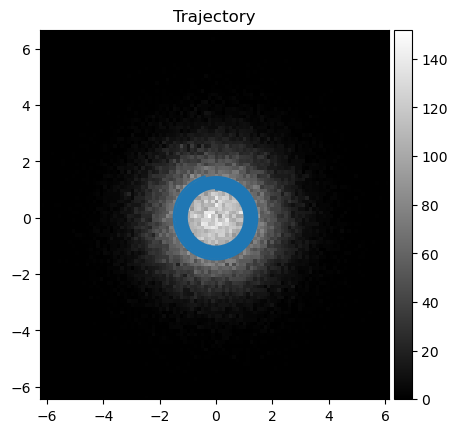

In [30]:
#Creation of Constants and Trajectory------------------------------------------------------
#create the normal distribution 
mu = np.zeros((2))
covar= np.diag((2,2))
target = np.random.multivariate_normal(mu, covar, 100000).T

#create the time horizon
t = 50
time, dt = np.linspace(0, t, 3001, retstep=True)

#create the dynamics array for x 
b = 0
dyn = np.array([[ 0,  1],
                [-1, -b]])
#intialize the initial condition.
x0 = np.array([[0],
               [1]])
x = x0 

#create storage for all of our x locations
x_arr = np.ndarray((2,len(time)))

#solve for our trajectory.
for i in range(len(time)):
    x_arr[:,i] = x.flatten()
    x_dot = dyn @ x 
    x = x + dt * x_dot

#Creation of Fourier Constants and Subspace Limits-----------------------------------------
#create the indices over which we will be computing the Fourier Basis Function
#choose our coefficients so that we don't have more than 20, or less than 5
k_coeffs = np.array([10, 10])
k_rows,k_cols = np.indices((k_coeffs[0],k_coeffs[1]))

#create the size of our subspace and where we will store our c_k and phi_k value.
bounds = subspace(target)
ck = np.zeros((k_coeffs[0],k_coeffs[1]))
pk = np.zeros((k_coeffs[0],k_coeffs[1]))

#ck using Fourier Basis--------------------------------------------------------------------
#iterate over each timestep in the horizon
for ii in range(time.size):
    #iterate over all the indices that we have. 
    for i in range(k_coeffs[0]):
        for j in range(k_coeffs[1]):

            #fourier only accepts numpy arrays, so we convert into an index.
            index = np.array([k_rows[i,j],k_cols[i,j]])

            #find the ck matrix for the given timestep.         
            ck[i,j] += fourier(index, bounds, x_arr[:, ii], 2) * dt
            
#Finish the integral
ck = 1/t * ck

#pk using the Fourier Basis-----------------------------------------------------------------
# #define our subspace indices based on our bounds.
# ii = bounds[0,0] # x-dimension
# jj = bounds[0,1] # y-dimension

# #iterate over our subspace indices.
# while jj < bounds[1,1]:                     #y-dimension loop
#     ii = bounds[0,0]                         #set x-dimension to the lower boundary.
#     while ii < bounds[1, 0]:                #x-dimension loop
#         sub_index = np.array([ii, jj])

#         #find the px value for the given sub_index.
#         px = det(2 * pi * covar)**-0.5 * exp(-0.5 * ((sub_index - mu).T) @ inv(covar) @ (sub_index - mu))

#         #iterate over our fourier basis coefficient indices.
#         for i in range(k_coeffs[0]):
#             for j in range(k_coeffs[1]):

#                 #fourier only accepts numpy arrays, so we convert into an index.
#                 k_index = np.array([k_rows[i,j],k_cols[i,j]])

#                 #find the pk matrix for the given timestep.         
#                 pk[i,j] += px * fourier(k_index, bounds, sub_index, 2)

#         ii += 1
    
#     jj += 1

#pk using the Fourier Basis-----------------------------------------------------------------
#define our subspace based on our bounds.
sub_x, sub_y = np.meshgrid(np.arange(bounds[0,0], bounds[1,0] + 1), 
                           np.arange(bounds[0,1], bounds[1,1] + 1))

#iterate over our subspace indices.
for ii in range(sub_x.shape[0]):        #number of rows
    for jj in range(sub_y.shape[1]):    #number of columns
        sub_index = np.array([sub_x[ii, jj], sub_y[ii, jj]])

        #find the px value for the given sub_index.
        px = det(2 * pi * covar)**-0.5 * exp(-0.5 * ((sub_index - mu).T) @ inv(covar) @ (sub_index - mu))

        #iterate over our fourier basis coefficient indices.
        for i in range(k_coeffs[0]):
            for j in range(k_coeffs[1]):

                #fourier only accepts numpy arrays, so we convert into an index.
                k_index = np.array([k_rows[i,j],k_cols[i,j]])

                #find the pk matrix for the given timestep.         
                pk[i,j] += px * fourier(k_index, bounds, sub_index, 2)


#Defining the ergodic metric. -------------------------------------------------------------------------
lamb = (1 + norm(k_coeffs)**2)**(-1 * ((2 + 1) / 2))
epsilon = np.sum(lamb * np.abs(np.subtract(ck, pk))**2)

print(epsilon)

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
divider = make_axes_locatable(axs) 

#Creation of the colormap and the colorbar. 
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs.hist2d(target[0,:], target[1,:], bins=100, cmap="gray")
fig.colorbar(im[3], cax=cax, orientation='vertical')
axs.set_aspect("equal")
axs.set_title("Distribution")

# #Plot the intitial distribution on the second figure.
# axs[1].scatter(target[0,:], target[1,:], c='orange')
# axs[1].axis("equal")
# axs[1].set_title("Samples")

#Plot the trajectory as well. 
axs.plot(x_arr[0, :],x_arr[1, :])
axs.axis("equal")
axs.set_title("Trajectory")

In [27]:
def metric(mu, covar, time, distribution, trajectory, K_f):
    '''
    Get the boundaries of a subspace given a n x m trajecotry in n-dimensional space.

    Parameters
    ----------
    mu: np.array
        n-dimensional mu of the Gaussian.

    covar: np.array
        n x n dimensional covariance of the Guassian. 

    time: np.array
        m dimensional array of the time. 

    distribution: np.array
        This a n x m distribution in n-dimensional space over m samples

    trajectory: np.array
        This a n x m trajectory in n-dimensional space over m timesteps

    K_f: np.array
        Number of coefficients in the Fourier Basis Function
    
    Returns
    -------
    epsilon: float
        Ergodic Metric Coefficient 
    '''

    #Creation of Fourier Constants and Subspace Limits-----------------------------------------
    #create the indices over which we will be computing the Fourier Basis Function
    #choose our coefficients so that we don't have more than 20, or less than 5
    k_coeffs = np.array([K_f, K_f])
    k_rows,k_cols = np.indices((k_coeffs[0],k_coeffs[1]))

    #create the size of our subspace and where we will store our c_k and phi_k value.
    bounds = subspace(distribution)
    ck = np.zeros((k_coeffs[0],k_coeffs[1]))
    pk = np.zeros((k_coeffs[0],k_coeffs[1]))

    #ck using Fourier Basis--------------------------------------------------------------------
    #iterate over each timestep in the horizon
    for ii in range(time.size):
        #iterate over all the indices that we have. 
        for i in range(k_coeffs[0]):
            for j in range(k_coeffs[1]):

                #fourier only accepts numpy arrays, so we convert into an index.
                index = np.array([k_rows[i,j],k_cols[i,j]])

                #find the ck matrix for the given timestep.         
                ck[i,j] += fourier(index, bounds, trajectory[:, ii], 2) * dt
                
    #Finish the integral.
    ck = 1/time[-1] * ck

    #pk using the Fourier Basis-----------------------------------------------------------------
    #define our subspace indices based on our bounds.
    # sub_x, sub_y = np.meshgrid(np.arange(bounds[0,0], bounds[1,0] + 1), 
    #                         np.arange(bounds[0,1], bounds[1,1] + 1))
    
    rangex, dx = np.linspace(bounds[0,0], bounds[1,0] + 1, 100, retstep=True)
    rangey, dy = np.linspace(bounds[0,1], bounds[1,1] + 1, 100, retstep=True)

    sub_x, sub_y = np.meshgrid(rangex, rangey)

    #iterate over our subspace indices.
    for ii in range(sub_x.shape[0]):        #number of rows
        for jj in range(sub_y.shape[1]):    #number of columns
            sub_index = np.array([sub_x[ii, jj], sub_y[ii, jj]])

            #find the px value for the given sub_index.
            px = det(2 * pi * covar)**-0.5 * exp(-0.5 * ((sub_index - mu).T) @ inv(covar) @ (sub_index - mu))

            #iterate over our fourier basis coefficient indices.
            for i in range(k_coeffs[0]):
                for j in range(k_coeffs[1]):

                    #fourier only accepts numpy arrays, so we convert into an index.
                    k_index = np.array([k_rows[i,j],k_cols[i,j]])

                    #find the pk matrix for the given timestep.         
                    pk[i,j] += px * fourier(k_index, bounds, sub_index, 2) * dy * dx


    #Defining the ergodic metric. -------------------------------------------------------------------------
    lamb = (1 + norm(k_coeffs)**2)**(-1 * ((2 + 1) / 2))
    epsilon = np.sum(lamb * np.abs(np.subtract(ck, pk))**2)

    return epsilon

metric(mu, covar, time, target, x_arr, 10)

0.006568998137017204

In [34]:
#Creation of Constants and Trajectory------------------------------------------------------
#create the normal distribution 
mu = np.zeros((2))
covar= np.diag((2,2))
target = np.random.multivariate_normal(mu, covar, 100000).T

#create the time horizon
t = 100
time, dt = np.linspace(0, t, 1001, retstep=True)

#create the epsilon storage across the time horizons and b. 

#create the boundaries of b and t.
tBounds = np.arange(5,100,5)
bBounds = [-8, 20]

#create an epsilon storage array
eps_arr = np.ndarray((np.arange(bBounds[0],bBounds[1]).shape[0]))

jk = 0 

for b in np.arange(bBounds[0],bBounds[1]):

    #create the dynamics array for x 
    dyn = np.array([[ 0,  1],
                    [-1, -b]])
    
    #intialize the initial condition.
    x0 = np.array([[0],
                [1]])
    x = x0 

    #create storage for all of our x locations
    x_arr = np.ndarray((2,len(time)))

    #solve for our trajectory.
    for i in range(len(time)):
        x_arr[:,i] = x.flatten()
        x_dot = dyn @ x 
        x = x + dt * x_dot

    eps = metric(mu, covar, time, target, x_arr, 10)
    eps_arr[jk] = eps
    jk += 1
    # print(jk)


Text(0.5, 1.0, 'Ergodic Metric')

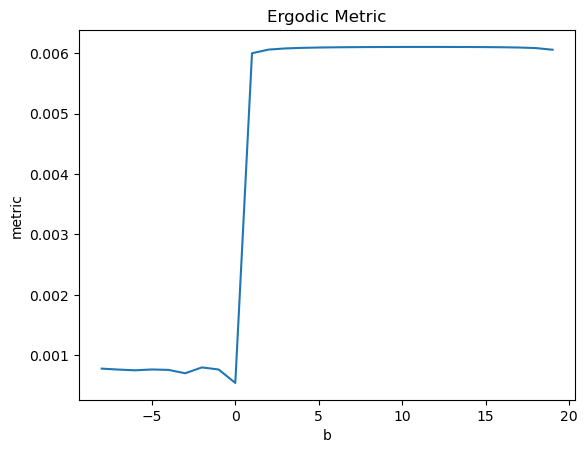

In [35]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()

axs.plot(np.arange(bBounds[0],bBounds[1]), eps_arr)
axs.set_xlabel("b")
axs.set_ylabel("metric")
axs.set_title("Ergodic Metric")
